# Modular Multimodal Fake News Detector

## Setup

If running on Google Colab the following install is enough.

In [1]:
# dependencies
!pip install imagehash

If running locally, run the following

In [ ]:
!pip install -r requirements.txt

In [ ]:
# imports
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image, ImageFile
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)
from torch.utils.data import Dataset
from transformers import (
    AutoModel,
    AutoTokenizer,
    BertModel,
    BertTokenizer,
    DebertaModel,
    DebertaTokenizer,
    ModernBertModel,
    ViTModel,
    SwinModel,
    Trainer,
    TrainingArguments
)
import warnings
import imagehash
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from safetensors.torch import save_file

# Ensure truncated images can be loaded
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Text and image model described in the project report

text_models = [
    'google-bert/bert-base-uncased',
    'microsoft/deberta-base',
    'answerdotai/ModernBERT-base'
    ]

image_models = [
    'microsoft/resnet-50',
    'google/vit-base-patch16-224',
    'microsoft/swin-base-patch4-window7-224'
]

text_model_name=text_models[1]
image_model_name=image_models[2]

## Data preparation

### Dataset downloading

In [4]:
# Fakeddit
!curl -L "https://docs.google.com/uc?export=download&id=1Z99QrwpthioZQY2U6HElmnx8jazf7-Kv" -o fakeddit.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.5M  100 15.5M    0     0  5004k      0  0:00:03  0:00:03 --:--:-- 5805k


In [5]:
# IFND
# Download the dataset from Kaggle
# https://www.kaggle.com/datasets/sonalgarg174/ifnd-dataset?select=IFND.csv

### Image downloading

In [9]:
def download_images(path, url_column, id_column, output_folder, delimiter, num_samples=20000):
    """
    Downloads the images from the image urls in the datasets
    """
    os.makedirs(output_folder, exist_ok=True)

    session = requests.Session()

    # define maximum number of retries per image
    retries = Retry(
        total=2,
        backoff_factor=0.3,
        status_forcelist=[500, 502, 503, 504]
    )

    adapter = HTTPAdapter(max_retries=retries)
    session.mount("http://", adapter)
    session.mount("https://", adapter)

    headers = {
        "user-agent": "curl/7.68.0",
        "accept": "*/*"
    }

    # download placeholder images for comparison
    if path == 'ifnd.csv':
      placeholder_row = {'Image': 'https://images.indianexpress.com/2020/12/express-photo-38-11.jpg?resize=450,250', 'id': '3199'}
    else:
      placeholder_row = {'id': 'ckm2j5y', 'image_url': 'http://i.imgur.com/KC2WyYB%2ejpg'}

    with open(path, 'r', encoding="ISO-8859-1") as file:
        reader = list(csv.DictReader(file, delimiter=delimiter))
        random.shuffle(reader)
        reader.insert(0, placeholder_row)
        count = 0
        for i, row in enumerate(reader):
            if url_column in row and row[url_column]:
                url = row[url_column]
                img_id = row[id_column]

                file_name = os.path.join(output_folder, f'{img_id}.jpg')

                if os.path.exists(file_name):
                    continue
                try:

                    response = session.get(url, stream=True, headers=headers, timeout=(1,3))
                    response.raise_for_status()

                    # write the file to folder
                    with open(file_name, 'wb') as img_file:
                        for chunk in response.iter_content(1024):
                            img_file.write(chunk)
                    count += 1
                    print(f'Downloaded: {file_name}')
                except requests.RequestException as e:
                    print(f'Failed to download {url}: {e}')

            if count % 100 == 0 and count != 0:
                print(f"\n\nDownloaded {count} images succesfully!\n\n")

            if count >= num_samples:
                break

download_images(path='fakeddit.tsv', url_column='image_url', id_column='id', output_folder='downloaded_images', delimiter='\t', num_samples=30000)
download_images(path='ifnd.csv', url_column='Image', id_column='id', output_folder='downloaded_images_ifnd', delimiter=',', num_samples=10000)

Downloaded: downloaded_images/ckm2j5y.jpg
Failed to download https://preview.redd.it/5afn6rn2xvb31.jpg?width=320&crop=smart&auto=webp&s=f98fd5d67637a02ba673bbc9ca1d06ae4cf84971: 404 Client Error: Not Found for url: https://preview.redd.it/5afn6rn2xvb31.jpg?width=320&crop=smart&auto=webp&s=f98fd5d67637a02ba673bbc9ca1d06ae4cf84971
Downloaded: downloaded_images/5upw8w.jpg
Downloaded: downloaded_images/cn18ex.jpg
Downloaded: downloaded_images/1voe05.jpg
Downloaded: downloaded_images/5ls5nx.jpg
Downloaded: downloaded_images/czj5ld.jpg
Downloaded: downloaded_images/c67ebq.jpg
Downloaded: downloaded_images/3wdrr9.jpg
Downloaded: downloaded_images/6argpq.jpg
Downloaded: downloaded_images/devaltf.jpg
Downloaded: downloaded_images/31920f.jpg
Downloaded: downloaded_images/d15xym8.jpg
Downloaded: downloaded_images/4tolaj.jpg
Downloaded: downloaded_images/b2xqml.jpg
Downloaded: downloaded_images/5ynuab.jpg
Downloaded: downloaded_images/4o4yer.jpg
Downloaded: downloaded_images/9advli.jpg
Downloaded:

Failed to download https://cmsimages.tribuneindia.com/gallary_content/2020/9/2020_9$smallthumbimg_1270532819.jpg: HTTPSConnectionPool(host='cmsimages.tribuneindia.com', port=443): Max retries exceeded with url: /gallary_content/2020/9/2020_9$smallthumbimg_1270532819.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x79d7e69311d0>, 'Connection to cmsimages.tribuneindia.com timed out. (connect timeout=1)'))
Downloaded: downloaded_images_ifnd/1405.jpg
Downloaded: downloaded_images_ifnd/36363.jpg


Failed to download  https://cmsimages.tribuneindia.com/gallary_content/2020/11/2020_11$smallthumbimg_1095138757.jpg: HTTPSConnectionPool(host='cmsimages.tribuneindia.com', port=443): Max retries exceeded with url: /gallary_content/2020/11/2020_11$smallthumbimg_1095138757.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x79d7e6933390>, 'Connection to cmsimages.tribuneindia.com timed out. (connect timeout=1)'))


Failed to download https://cmsimages.tribuneindia.com/gallary_content/2020/12/2020_12$smallthumbimg_2087166157.jpg: HTTPSConnectionPool(host='cmsimages.tribuneindia.com', port=443): Max retries exceeded with url: /gallary_content/2020/12/2020_12$smallthumbimg_2087166157.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x79d7e2487c90>, 'Connection to cmsimages.tribuneindia.com timed out. (connect timeout=1)'))
Downloaded: downloaded_images_ifnd/34217.jpg
Downloaded: downloaded_images_ifnd/2675.jpg
Downloaded: downloaded_images_ifnd/34265.jpg


### Preprocessing

In [ ]:
def update_paths(path, url_column, id_column, title_column, output_folder, updated_path, delimiter, placeholder_image):
    """
    Replaces url links to filesystem paths of properly downloaded images.
    Ommits images that are placeholder imgur image, i.e. when the image is no longer available.
    Also omits images with incorrectly encoded titles.
    """
    # imgur placeholder image that is verified to be downloaded when the image is missing
    hash0 = imagehash.average_hash(Image.open(placeholder_image)) if placeholder_image is not None and os.path.exists(placeholder_image) else None

    updated_rows = []

    with open(path, 'r', encoding='ISO-8859-1') as file:
        reader = csv.DictReader(file, delimiter=delimiter)
        fieldnames = reader.fieldnames
        rows = list(reader)
        if len(rows) == 0:
            print(f"Unable to load any sample from the input {path}")
        for i, row in enumerate(rows):
            if url_column in row and row[url_column]:
                img_id = row[id_column]
                image_path = os.path.join(output_folder, f'{img_id}.jpg')
                if os.path.exists(image_path):
                    try:
                        # verify the text is well encoded
                        text = row[title_column]
                        encoded_decoded_text = bytes(text,'iso-8859-1').decode('utf-8')
                        if text != encoded_decoded_text:
                            raise Exception(f"image has label encoding error: {text}")

                        # try if the image can be opened
                        im = Image.open(image_path)

                        if hash0 is not None:
                            hash1 = imagehash.average_hash(im)
                            cutoff = 5  # maximum bits that could be different between the hashes

                            if hash0 - hash1 < cutoff:
                                raise Exception("image is placeholder")

                        row[url_column] = image_path
                        updated_rows.append(row)
                    except Exception as e:
                        print(f"failed at {image_path} {str(e)}")
    if len(updated_rows) == 0:
        print(f"Unable to load any sample from the input {path}")
    with open(updated_path, 'w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames, delimiter=delimiter)
        writer.writeheader()
        writer.writerows(updated_rows)

update_paths(path='fakeddit.tsv',
             url_column='image_url',
             id_column='id',
             title_column='clean_title',
             output_folder='downloaded_images',
             updated_path='fakeddit_with_paths.tsv',
             delimiter='\t',
             placeholder_image='downloaded_images/ckm2j5y.jpg')
update_paths(path='ifnd.csv',
             url_column='Image',
             id_column='id',
             title_column='Statement',
             output_folder='downloaded_images_ifnd',
             updated_path='ifnd_with_paths.csv',
             delimiter=',',
             placeholder_image='downloaded_images_ifnd/3199.jpg')

failed at downloaded_images/ckm2j5y.jpg image is placeholder
failed at downloaded_images_ifnd/3199.jpg image is placeholder
failed at downloaded_images_ifnd/34217.jpg 'utf-8' codec can't decode byte 0x92 in position 33: invalid start byte
failed at downloaded_images_ifnd/34265.jpg 'utf-8' codec can't decode byte 0x92 in position 58: invalid start byte
failed at downloaded_images_ifnd/36363.jpg image has label encoding error: BJPï¿½s Maharashtra test begins tomorrow ï¿½ in Pawar fortress of Baramati
failed at downloaded_images_ifnd/37648.jpg image has label encoding error: ï¿½Hindus should have self-respectï¿½ ï¿½ Bajrang Dal holds rally to boycott Christmas in Silchar
failed at downloaded_images_ifnd/47373.jpg 'utf-8' codec can't decode byte 0xd0 in position 44: invalid continuation byte


## Dataset

### Loading

In [11]:
# 6-way labels dataset
df_6way = pd.read_csv('fakeddit_with_paths.tsv', delimiter='\t', encoding='ISO-8859-1')
df_6way = df_6way[['id','clean_title', 'image_url', '2_way_label', '6_way_label']]
df_6way = df_6way.dropna()
df_6way = df_6way.loc[df_6way['image_url'].str.startswith('downloaded_images/')]
df_6way = df_6way.rename(columns={'clean_title': 'Title', 'image_url': 'Image', '2_way_label': 'Label2', '6_way_label': 'Label6'})
df_6way.head()

id                                              Title  \
0  5ynuab                  tips for handling office conflict   
1  b2xqml  the way the cars shadows keep the snow from me...   
2  9advli     rare pic of jesus christ getting his degree ad   
3  4tolaj   granville waldegrave torpedo moving through time   
4  5ls5nx                        just how dangerous is alexa   

                          Image  Label2  Label6  
0  downloaded_images/5ynuab.jpg       0       1  
1  downloaded_images/b2xqml.jpg       1       0  
2  downloaded_images/9advli.jpg       0       2  
3  downloaded_images/4tolaj.jpg       0       1  
4  downloaded_images/5ls5nx.jpg       0       5

In [12]:
# 2-way labels dataset
df_2way = pd.read_csv('ifnd_with_paths.csv', delimiter=',', encoding='windows-1252')
df_2way = df_2way[['id','Statement', 'Image', 'Label']]
df_2way = df_2way.dropna()
df_2way = df_2way.loc[df_2way['Image'].str.startswith('downloaded_images_ifnd/')]
df_2way = df_2way.rename(columns={'Statement': 'Title', 'Label': 'Label2'})
df_2way['Label2'] = df_2way['Label2'].replace({'TRUE': 1, 'Fake': 0})
df_2way.head()

id                                              Title  \
0   1405  NIA files chargesheet against JeM chief Masood...   
1   2675  Another staff member of AIIMS dies due to coro...   
2  22976  Mukhtar Abbas Naqvi Slams Muslim Board On Ayod...   
3  23302  Governor has rejected 48 hour Shiv Sena reques...   

                              Image  Label2  
0   downloaded_images_ifnd/1405.jpg    True  
1   downloaded_images_ifnd/2675.jpg    True  
2  downloaded_images_ifnd/22976.jpg    True  
3  downloaded_images_ifnd/23302.jpg    True

In [13]:
# combined the 10000 ifnd samples with random sampled fakeddit
df_sample_temp = df_6way.sample(min(20000, df_6way.shape[0]), random_state=42)
df_sample_temp = df_sample_temp[['id','Title', 'Image', 'Label2']]
df_2way = pd.concat([df_2way, df_sample_temp], ignore_index=True)
df_2way = df_2way.rename(columns={'Label2': 'Label'})

df_6way = df_6way.rename(columns={'Label6': 'Label'})

### Exploratory Analysis

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         10000 non-null  int64 
 1   Title      10000 non-null  object
 2   Image      10000 non-null  object
 3   Label      10000 non-null  int64 
 4   Label_str  10000 non-null  object
dtypes: int64(2), object(3)
memory usage: 468.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          30000 non-null  object
 1   Title       30000 non-null  object
 2   Image       30000 non-null  object
 3   Label2      30000 non-null  int64 
 4   Label       30000 non-null  int64 
 5   Label_str   30000 non-null  object
 6   Label2_str  30000 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.8+ MB
None

Value counts for Label2 (string):

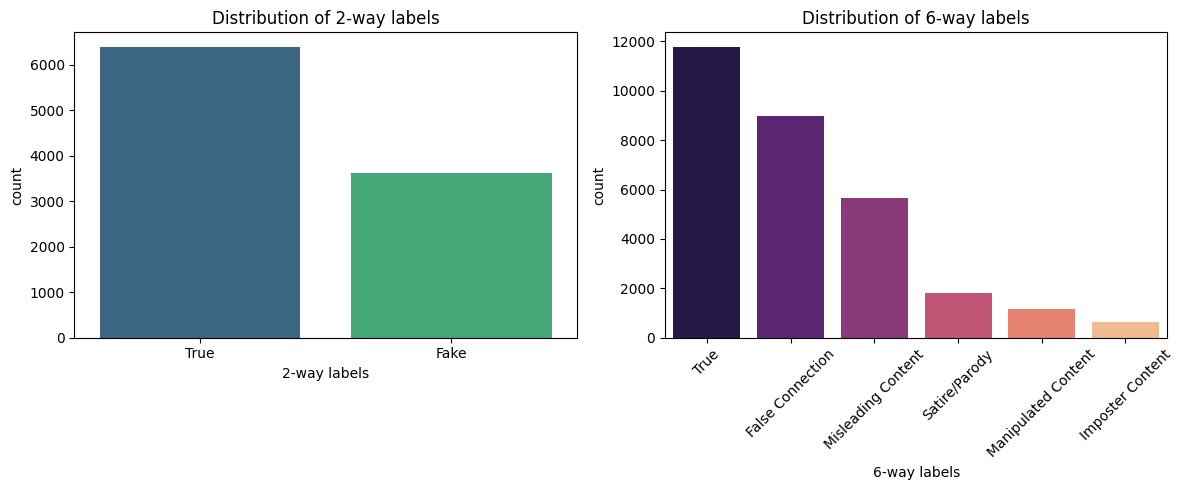

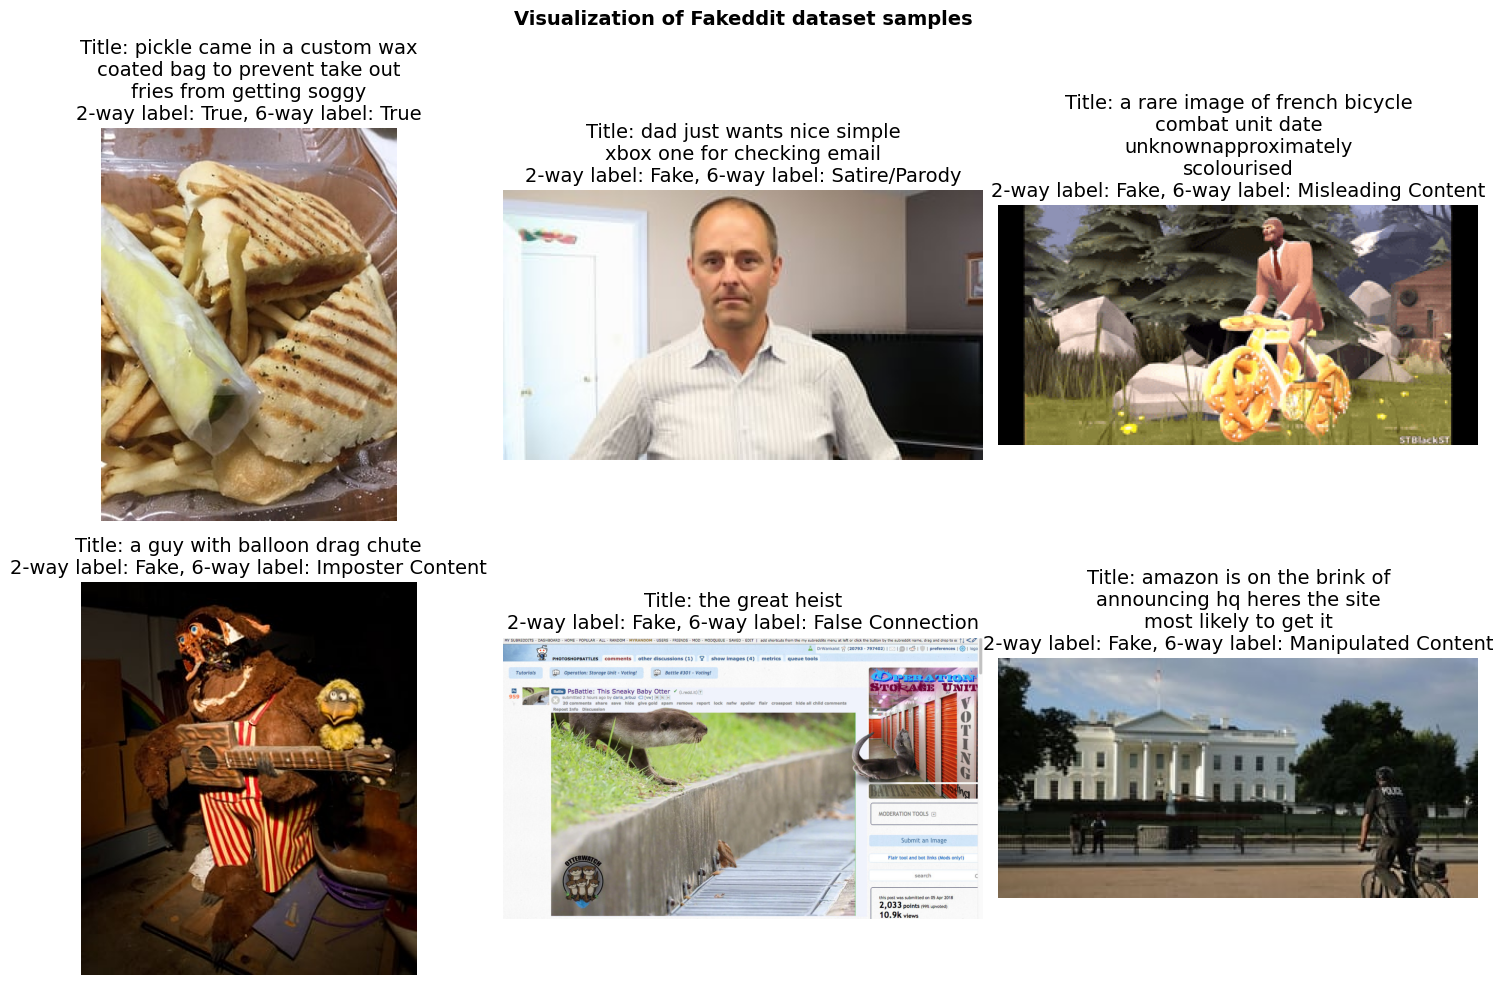

In [ ]:
label2_mapping = {1: "True", 0: "Fake"}
label6_mapping = {0: "True", 1: "Satire/Parody", 2: "Misleading Content", 3: "Imposter Content", 4: "False Connection", 5: "Manipulated Content"}

df_2way['Label_str'] = df_2way['Label'].map(label2_mapping)
df_6way['Label_str'] = df_6way['Label'].map(label6_mapping)
df_6way['Label2_str'] = df_6way['Label2'].map(label2_mapping)

# Confirm that the totals fit for both 2-way and 6-way samples
print("DataFrame Info:")
print(df_2way.info())
print(df_6way.info())

print("\nValue counts for Label2 (string):")
print(df_2way['Label_str'].value_counts())

print("\nValue counts for Label6 (string):")
print(df_6way['Label_str'].value_counts())

# Plot the distributions of Label2 and Label6
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax = sns.countplot(x='Label_str', data=df_2way, palette="viridis", hue='Label_str', legend=False)
ax.set(xlabel='2-way labels')
plt.title('Distribution of 2-way labels')

plt.subplot(1, 2, 2)
ax = sns.countplot(x='Label_str', data=df_6way, palette="magma", hue='Label_str')
ax.set(xlabel='6-way labels')
ax.tick_params(axis='x', labelrotation = 45)
plt.title('Distribution of 6-way labels')

plt.tight_layout()
plt.show()

df_selected = df_6way.groupby('Label', as_index=False).sample(1)

plt.figure(figsize=(15, 10))
plt.suptitle("Visualization of Fakeddit dataset samples", fontsize=14, fontweight='bold')
for i, (_, row) in enumerate(df_selected.iterrows()):
    img_path = row['Image']
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title = f"Title: {"\n".join(textwrap.wrap(row['Title'], width=30)) }\n2-way label: {row['Label2_str']}, 6-way label: {row['Label_str']}"
    plt.title(title, fontsize=14)
plt.tight_layout()
plt.savefig('image_labels6.png', dpi=300)
plt.show()

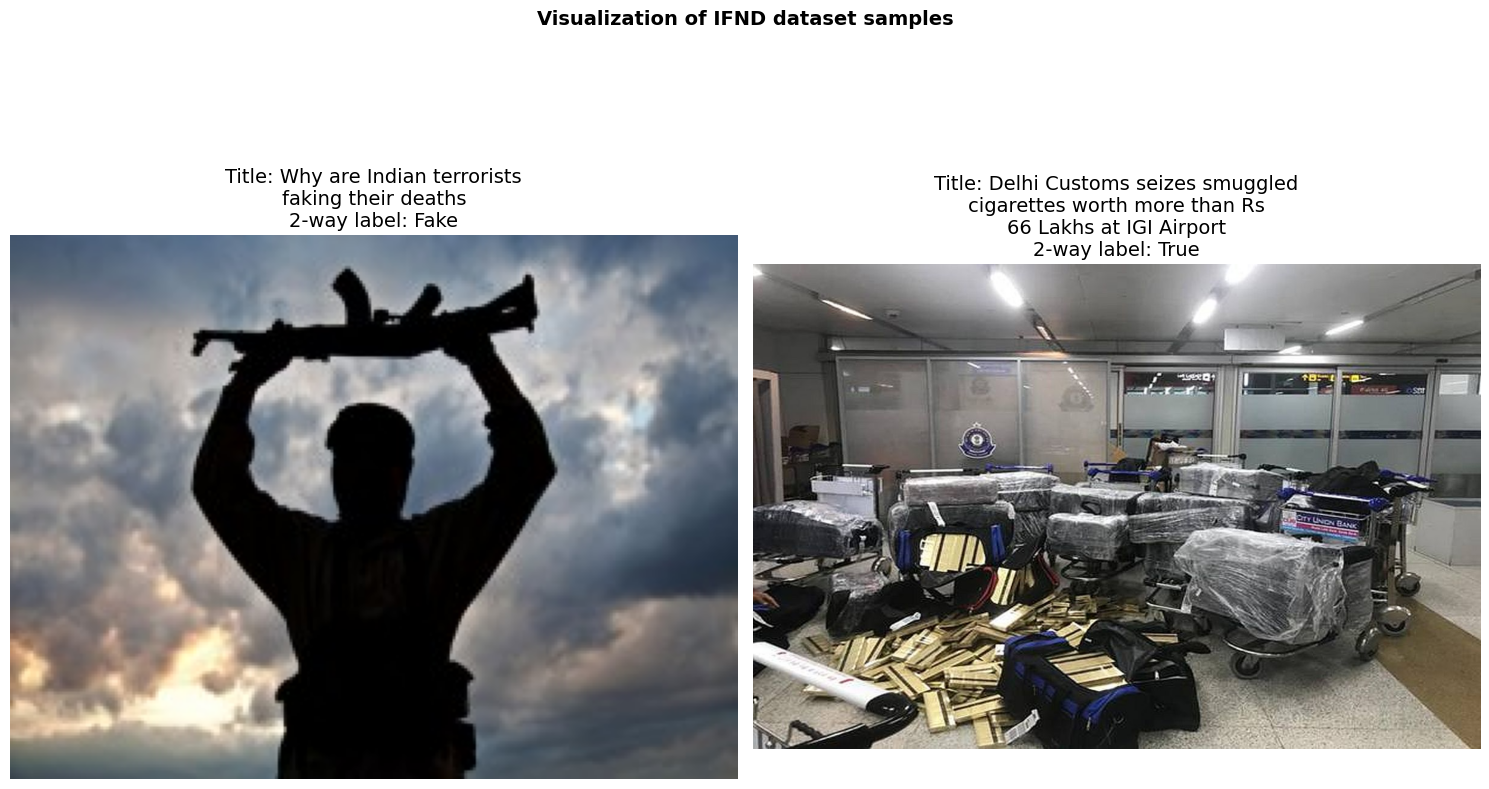

In [ ]:
# IFND dataset
df_selected = df_2way.groupby('Label', as_index=False).sample(1)
plt.figure(figsize=(15, 10))
plt.suptitle("Visualization of IFND dataset samples", fontsize=14, fontweight='bold')
for i, (_, row) in enumerate(df_selected.iterrows()):
    img_path = row['Image']
    img = Image.open(img_path)

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

    title = f"Title: {"\n".join(textwrap.wrap(row['Title'], width=30))}\n2-way label: {row['Label_str']}"
    plt.title(title, fontsize=14)
plt.tight_layout()
plt.savefig('image_labels2.png', dpi=300, bbox_inches="tight")
plt.show()

### Utils

In [ ]:
# controls loaded dataset
num_labels = 6

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="macro", zero_division=0)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def get_datasets(num_labels=2):
    """
    Returns train, test, validation datasets splits based on number of labels - 2 or 6
    """
    assert num_labels == 2 or num_labels == 6, "Labels are 2-way and 6-way only"

    df = df_2way if num_labels == 2 else df_6way

    train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

    return train_df, val_df, test_df

In [15]:
# Dataset class for loading images
class FakedditDataset(Dataset):
    """
    PyTorch dataset class
    """
    def __init__(self, dataframe, tokenizer, image_transform, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        encoded_text = self.tokenizer.encode_plus(
            row["Title"],
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        image = Image.open(row["Image"]).convert("RGB")
        pixel_values = self.image_transform(image).float()

        label = torch.tensor(row['Label'], dtype=torch.long)

        return {
            'input_ids': encoded_text['input_ids'].squeeze(0),
            'attention_mask': encoded_text['attention_mask'].squeeze(0),
            'pixel_values': pixel_values,
            'labels': label
        }

## Baseline Models

In [ ]:
class TextClassifier(nn.Module):
    """
    Text classification model class
    """

    def __init__(self, text_model_name, num_labels, proj_dim=224, dropout_prob=0.1):
        super(TextClassifier, self).__init__()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if 'deberta' in text_model_name.lower():
            # Deberta model does not support auto device mapping
            self.text_model = DebertaModel.from_pretrained(
                text_model_name).to(device)
        elif 'modernbert' in text_model_name.lower():
            self.text_model = ModernBertModel.from_pretrained(
                text_model_name, device_map="auto")
        elif text_model_name == 'google-bert/bert-base-uncased':
            self.text_model = BertModel.from_pretrained(
                text_model_name, device_map="auto")
        else:
            # try to load any other model, but this might not work
            self.text_model = AutoModel.from_pretrained(
                text_model_name).to(device)

        text_hidden_size = self.text_model.config.hidden_size
        self.proj = nn.Linear(text_hidden_size, proj_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.loss_fct = nn.CrossEntropyLoss()
        self.classifier = nn.Sequential(
            nn.Linear(proj_dim, 224),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(224, num_labels)
        )

        print(f'Loaded {num_labels}-way labels\nText encoder: {text_model_name}')

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.text_model(
            input_ids=input_ids, attention_mask=attention_mask)
        # Extract the [CLS] token output.
        cls = outputs.last_hidden_state[:, 0, :]
        emb = self.proj(cls)
        emb = self.dropout(emb)
        logits = self.classifier(emb)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)
        return {"loss": loss, "logits": logits} if loss is not None else logits

class ImageClassifier(nn.Module):
    """
    Image classification model class
    """

    def __init__(self, image_model_name, num_labels, proj_dim=224, dropout_prob=0.1):
        super(ImageClassifier, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image_model_name = image_model_name

        if "vit" in image_model_name.lower():
            self.image_model = ViTModel.from_pretrained(
                image_model_name, device_map="auto")
            image_hidden_size = self.image_model.config.hidden_size
        elif "swin" in image_model_name.lower():
            self.image_model = SwinModel.from_pretrained(
                image_model_name, device_map="auto")
            image_hidden_size = self.image_model.config.hidden_size
        elif "resnet" in image_model_name.lower():
            # If using a ResNet from Hugging Face, you can load it via AutoModel.
            self.image_model = AutoModel.from_pretrained(
                image_model_name, device_map="auto")
            image_hidden_size = self.image_model.config.hidden_sizes[-1]
        else:
            self.image_model = AutoModel.from_pretrained(
                image_model_name).to(device)
            image_hidden_size = self.image_model.config.hidden_size

        self.proj = nn.Linear(image_hidden_size, proj_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.loss_fct = nn.CrossEntropyLoss()
        self.classifier = nn.Sequential(
            nn.Linear(proj_dim, 224),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(224, num_labels)
        )

        print(f'Loaded {num_labels}-way labels\nImage encoder: {image_model_name}')

    def forward(self, pixel_values=None, labels=None, **kwargs):
        outputs = self.image_model(pixel_values=pixel_values)

        if "resnet" not in self.image_model_name.lower():
            # Image branch: assume the model outputs a last_hidden_state with a CLS token.
            cls = outputs.last_hidden_state[:, 0, :]
        else:
            cls = torch.mean(outputs.last_hidden_state, dim=[2, 3])

        emb = self.proj(cls)
        emb = self.dropout(emb)
        logits = self.classifier(emb)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)
        return {"loss": loss, "logits": logits} if loss is not None else logits


if 'deberta' in image_model_name.lower():
    tokenizer = DebertaTokenizer.from_pretrained(text_model_name)
elif 'bert' in image_model_name.lower() and 'modernbert' not in image_model_name.lower():
    tokenizer = BertTokenizer.from_pretrained(text_model_name)
else:
    tokenizer = AutoTokenizer.from_pretrained(text_model_name)

train_df, val_df, test_df = get_datasets(num_labels=num_labels)

train_dataset = FakedditDataset(train_df, tokenizer, image_transform)
val_dataset = FakedditDataset(val_df, tokenizer, image_transform)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    dataloader_pin_memory=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy='epoch',
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to='none'
)

### Text-Only Classifier Training

In [ ]:
model = TextClassifier(text_model_name, num_labels=num_labels, proj_dim=224, dropout_prob=0.1)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

### Image-Only Classifier Training

In [ ]:
model = ImageClassifier(image_model_name, num_labels=num_labels, proj_dim=224, dropout_prob=0.1)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

## Fine-Tuning Multimodal Model

In [ ]:
class MultiModalClassifier(nn.Module):
    """
    Multimodal classification model class
    """

    def __init__(
        self,
        text_model_name,
        image_model_name,
        num_labels,
        hidden_dim=224,
        dropout_prob=0.1
    ):
        super(MultiModalClassifier, self).__init__()
        device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        if 'deberta' in text_model_name.lower():
            # Deberta model does not support auto device mapping
            self.text_model = DebertaModel.from_pretrained(
                text_model_name).to(device)
        elif 'modernbert' in text_model_name.lower():
            self.text_model = ModernBertModel.from_pretrained(
                text_model_name, device_map="auto")
        elif text_model_name == 'google-bert/bert-base-uncased':
            self.text_model = BertModel.from_pretrained(
                text_model_name, device_map="auto")
        else:
            # try to load any other model, but this might not work
            self.text_model = AutoModel.from_pretrained(
                text_model_name).to(device)

        text_hidden_size = self.text_model.config.hidden_size

        self.text_proj = nn.Linear(text_hidden_size, hidden_dim)

        self.image_model_name = image_model_name

        if "vit" in image_model_name.lower():
            self.image_model = ViTModel.from_pretrained(
                image_model_name, device_map="auto")
            image_hidden_size = self.image_model.config.hidden_size
        elif "swin" in image_model_name.lower():
            self.image_model = SwinModel.from_pretrained(
                image_model_name, device_map="auto")
            image_hidden_size = self.image_model.config.hidden_size
        elif "resnet" in image_model_name.lower():
            self.image_model = AutoModel.from_pretrained(
                image_model_name, device_map="auto")
            image_hidden_size = self.image_model.config.hidden_sizes[-1]
        else:
            # try to load any other model, but this might not work
            self.image_model = AutoModel.from_pretrained(
                image_model_name).to(device)
            image_hidden_size = self.image_model.config.hidden_size

        self.image_proj = nn.Linear(image_hidden_size, hidden_dim)

        self.loss_fct = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 224),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(224, num_labels)
        )

        print(f'Loaded {num_labels}-way labels\nText encoder: {text_model_name}\nImage encoder: {image_model_name}')

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Text branch: extract [CLS] token and project it
        text_outputs = self.text_model(
            input_ids=input_ids, attention_mask=attention_mask)
        text_cls = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        text_emb = self.text_proj(text_cls)

        image_outputs = self.image_model(pixel_values=pixel_values)

        if "resnet" in self.image_model_name.lower():
            image_cls = torch.mean(image_outputs.last_hidden_state, dim=[2, 3])
        else:
            # Assume the model outputs a last_hidden_state with a CLS token.
            image_cls = image_outputs.last_hidden_state[:, 0, :]

        image_emb = self.image_proj(image_cls)

        fused = torch.max(text_emb, image_emb)
        fused = self.dropout(fused)
        logits = self.classifier(fused)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else logits

if 'deberta' in image_model_name.lower():
    tokenizer = DebertaTokenizer.from_pretrained(text_model_name)
elif 'bert' in image_model_name.lower():
    tokenizer = BertTokenizer.from_pretrained(text_model_name)
else:
    tokenizer = AutoTokenizer.from_pretrained(text_model_name)

train_df, val_df, test_df = get_datasets(num_labels=num_labels)

train_dataset = FakedditDataset(train_df, tokenizer, image_transform)
val_dataset = FakedditDataset(val_df, tokenizer, image_transform)

model = MultiModalClassifier(
    text_model_name=text_model_name,
    image_model_name=image_model_name,
    num_labels=num_labels,
    hidden_dim=224,
    dropout_prob=0.1
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    dataloader_pin_memory=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy='epoch',
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

## Evaluation

In [ ]:
test_dataset = FakedditDataset(test_df, tokenizer, image_transform)

eval_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=64,
    do_eval=True,
    report_to='none'
)

model.eval()

trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

metrics = trainer.evaluate()
print(f"Test Acc: {metrics['eval_accuracy']:.4f} | Precision: {metrics['eval_precision']:.4f} | Recall: {metrics['eval_recall']:.4f}")

Test Acc: 0.8760 | Precision: 0.8438 | Recall: 0.7424


Visualization of confusion matrix to see which labels are problematic for classification

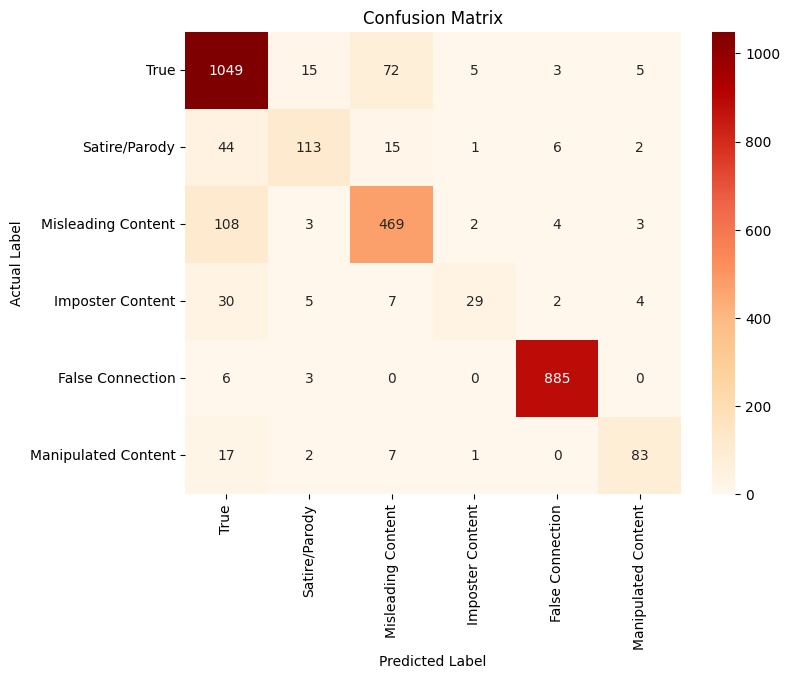

In [ ]:
if num_labels == 2:
    label_mapping = {1: "True", 0: "Fake"}
else:
    label_mapping = {0: "True", 1: "Satire/Parody", 2: "Misleading Content", 3: "Imposter Content", 4: "False Connection", 5: "Manipulated Content"}

predictions, labels, _ = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(labels, pred_labels)

cm_df = pd.DataFrame(
    cm,
    index=[label_mapping[i] for i in range(num_labels)],
    columns=[label_mapping[i] for i in range(num_labels)]
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="OrRd")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.savefig("cm.png", dpi=300, bbox_inches='tight')
plt.show()

## Saving the model

In [20]:
model_path = os.path.join('results', f"multimodal_model_{num_labels}way")
trainer.save_model(model_path)

metadata = {
    "model_type": "multimodal",
    "text_model_name": text_model_name,
    "image_model_name": image_model_name,
    "image_model_input_dim": "224",
    "num_labels": str(num_labels),
    "hidden_dim": "224",
    "dropout_prob": "0.1"
}

model_state = model.state_dict()
safetensors_path = os.path.join(model_path, "model.safetensors")
save_file(model_state, safetensors_path, metadata=metadata)

## Inference

In [ ]:
def classify(text, image_path, model, tokenizer, image_transform, device, max_length=128):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    image = Image.open(image_path).convert("RGB")
    pixel_values = image_transform(image).unsqueeze(0).to(device)
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        logits = outputs["logits"] if isinstance(outputs, dict) else outputs
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1)

    return pred.item(), probs.cpu().numpy()


Prediction Results:
Predicted Class: 1 (Satire/Parody)
Confidence: 0.8394

Class Probabilities:
True: 0.0713
Satire/Parody: 0.8394
Misleading Content: 0.0194
Imposter Content: 0.0064
False Connection: 0.0040
Manipulated Content: 0.0594


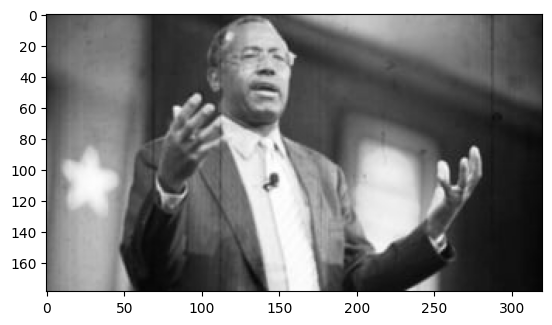

In [ ]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text = "ben carson calls for a return to a bygone era when people noticed him"
image = "image.jpg"

try:
    img = Image.open(image).convert("RGB")
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

predicted_class, probabilities = classify(text, image, model, tokenizer, image_transform, device)

plt.imshow(img)
plt.show

print(f"\nPrediction Results:")
print(f"Predicted Class: {predicted_class} ({label_mapping[predicted_class]})")
print(f"Confidence: {probabilities[0][int(predicted_class)]:.4f}")


print("\nClass Probabilities:")
for i, prob in enumerate(probabilities[0]):
    print(f"{label_mapping[i]}: {prob:.4f}")